# Using LSTM - Varying Length

In this notebook, we combine the dataset of fixed and varying length. Then, we train an LSTM layer on this data to predict the MRL for 5'UTRs of varying length.

In [1]:
import matplotlib as mpl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn import preprocessing
import random

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['agg.path.chunksize'] = 0
mpl.rcParams.update( mpl.rc_params() )
plt.rcParams.update({'font.size': 18})
#plt.rcParams.update({'text.usetex': True})
plt.rcParams.update({'text.latex.preamble': 'bold'})
plt.rc('font', family='serif')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import sequence

from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Activation
from keras.layers.core import Flatten

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, Layer, Dense, Dropout, MultiHeadAttention, LayerNormalization, Input, GlobalAveragePooling1D
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow import keras

from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split

## Useful Functions

In [8]:
def one_hot_encode(X_seq, seq_len=100):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    
    # Creat empty matrix.
    vectors=np.empty([len(X_seq),seq_len,4])
    
    # Iterate through UTRs and one-hot encode
    for i in range(len(X_seq)): 
        seq = X_seq[i].lower()
        a = np.array([nuc_d[x] for x in seq])
        vectors[i] = a
    return vectors

def inverse_code(l):
    if l == [1,0,0,0]:
        return 'A'
    elif l == [0,1,0,0]:
        return "C"
    elif l == [0,0,1,0]:
        return 'G'
    elif l == [0,0,0,1]:
        return 'T'
    else:
        return 'n'

def decode(X_seq, seq_len=100):
    # Creat empty matrix.
    vectors=[]
    
    # Iterate through UTRs and one-hot encode
    for i in range(len(X_seq)): 
        seq = list(X_seq[i])
        a = "".join([inverse_code(list(x)) for x in seq])
        vectors.append(a)
    return np.array(vectors)

def split_atg(X1,X,y):
    label_atg,atg,label_no_atg,no_atg = [], [], [], []
    for i in range(len(X1)):
        seq = ""
        for j in range(len(X1[i])-1):
            seq += X[i][j][0]
        seq += X[i][-1]
        if "ATG" in seq:
            atg.append(X1[i])
            label_atg.append(y[i])
        else:
            no_atg.append(X1[i])
            label_no_atg.append(y[i])
    return np.array(label_atg),np.array(atg),np.array(label_no_atg),np.array(no_atg) 


## Import data and split it into Training, Validation and Test sets

In [9]:
data_path = "Data/GSM4084997_varying_length_PREPROCESSED.csv.gz"
df = pd.read_csv(data_path, compression='gzip')
data_path2 = "Data/GSM3130435_egfp_unmod_1_PREPROCESSED.csv.gz"
df2 = pd.read_csv(data_path2, compression='gzip')
df.head()

,Unnamed: 0,utr,set,0,1,2,3,4,5,6,...,r8,r9,r10,r11,r12,total,rl,len,one-hot encoding,scaled_rl
0,30,CCTTCAATGATTACCTCTATCCCCA,random,291,448,539,529,527,338,170,...,0.035287,0.040289,0.049426,0.059276,0.113321,0.001592,4.300281,25,"[[0, 1, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0,...",-0.743234
1,3101,CTACGACGCTCCGACGTTCAACCCGCT,random,172,171,201,191,463,488,288,...,0.078099,0.071641,0.076364,0.072164,0.083046,0.001349,5.656860,27,"[[0, 1, 0, 0], [0, 0, 0, 1], [1, 0, 0, 0], [0,...",0.272356
2,21140,CCACATTCTCGGCCCCAATGCTCCACTC,random,337,392,560,447,417,309,109,...,0.036651,0.042373,0.054526,0.047254,0.122898,0.001448,4.150751,28,"[[0, 1, 0, 0], [0, 1, 0, 0], [1, 0, 0, 0], [0,...",-0.855179
3,60015,TACGTTTTGACCTTCGTTCATTTTG,random,210,177,181,200,421,478,297,...,0.077419,0.071114,0.076663,0.071114,0.071365,0.001340,5.645849,25,"[[0, 0, 0, 1], [1, 0, 0, 0], [0, 1, 0, 0], [0,...",0.264114
4,75065,TCCAAAAGTACATTCCATATTCTCCA,random,230,195,167,144,327,432,297,...,0.093710,0.068056,0.084204,0.084574,0.059441,0.001312,5.856299,26,"[[0, 0, 0, 1], [0, 1, 0, 0], [0, 1, 0, 0], [1,...",0.421665


In [10]:
df2.head()

,Unnamed: 0,utr,0,1,2,3,4,5,6,7,...,r9,r10,r11,r12,r13,rl,Selection,one-hot encoding,Length,scaled_rl
0,120605,CCACTCGATTAACATGTTAACAACATACTCGTCCGGCCGATCAGCG...,0.000137,0.000109,0.000057,0.000033,0.000015,0.000016,0.000009,0.000009,...,0.019283,0.033252,0.033252,0.027581,0.035877,3.039939,Selected Data,"[[0, 1, 0, 0], [0, 1, 0, 0], [1, 0, 0, 0], [0,...",50,-2.130922
1,11605,CAAATCATGTGCAGCCCTGGCGACCGTACTGCGGTACAAGAAAGTA...,0.000067,0.000070,0.000065,0.000048,0.000023,0.000020,0.000011,0.000011,...,0.024241,0.039457,0.039457,0.039840,0.038785,3.895109,Selected Data,"[[0, 1, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1,...",50,-1.600332
2,128224,GTTATACTAGAAGAAACTTGAGATTATGGAGCAGTCCGTCAAGGAC...,0.000088,0.000081,0.000059,0.000035,0.000017,0.000016,0.000009,0.000009,...,0.021591,0.028353,0.028353,0.028963,0.041985,3.334524,Selected Data,"[[0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 0, 1], [1,...",50,-1.948147
3,239107,CTTAGACAAAAACAACGCGCTTTCCAGTATGCGGAGCCTTGACGGT...,0.000078,0.000071,0.000060,0.000038,0.000025,0.000016,0.000010,0.000009,...,0.026617,0.038302,0.038302,0.032788,0.031043,3.575082,Selected Data,"[[0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 0, 1], [1,...",50,-1.798893
4,59082,GTATCAAATCACGGCCAACCCGACGGAGTACCCCGCGTCGATGGTC...,0.000044,0.000045,0.000050,0.000051,0.000033,0.000026,0.000015,0.000012,...,0.033080,0.051449,0.051449,0.046052,0.036447,4.593712,Selected Data,"[[0, 0, 1, 0], [0, 0, 0, 1], [1, 0, 0, 0], [0,...",50,-1.166885


In [11]:
df = df[["utr", "rl", "len"]]
df2 = df2[["utr", "rl"]]

In [12]:
X =np.concatenate((df['utr'][:100000].values,df2['utr'][:280000].values))

Y =np.concatenate((df['rl'][:100000].values,df2['rl'][:280000].values))

for x in range(380000):
    while len(X[x])<100:
        X[x] =X[x]+'n'
        


In [13]:
utr_one_hot_encoded = one_hot_encode(X,seq_len=100)

In [27]:
X_train, X_val, y_train, y_val = train_test_split(utr_one_hot_encoded, Y, test_size=0.2, random_state=25)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=25)

## Building and Training the model

In [41]:
batch_size = 64
input_dim = 100
input_dim2 = 4
units = 75
output_size = 1

def train_model(x, y, inp_len=50, nodes=40, nb_epoch=3):
    ''' Build model archicture and fit.'''
    model = Sequential()
    model.add(LSTM(units=75, input_shape=(100, 4), return_sequences=True))
    model.add(LSTM(units=75, input_shape=(100, 4), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=75, input_shape=(100, 4), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(Flatten())

    model.add(Dense(nodes))
    model.add(Activation('relu'))
    
    model.add(Dense(1))
    model.add(Activation('linear'))

    #compile the model
    adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='mean_squared_error', optimizer=adam)
    model.fit(x, y, batch_size=128, validation_data=(X_val,y_val), epochs=nb_epoch, verbose=1)
    return model

In [43]:
model = train_model(X_train, y_train, nb_epoch=10,
                   inp_len=100, nodes=50)

Epoch 1/10
2375/2375 [==============================] - 1856s 780ms/step - loss: 1.9996 - val_loss: 1.2073
Epoch 2/10
2375/2375 [==============================] - 1429s 602ms/step - loss: 1.1046 - val_loss: 0.8017
Epoch 3/10
2375/2375 [==============================] - 1389s 585ms/step - loss: 0.7775 - val_loss: 0.6604
Epoch 4/10
2375/2375 [==============================] - 1556s 655ms/step - loss: 0.6231 - val_loss: 0.5418
Epoch 5/10
2375/2375 [==============================] - 1643s 692ms/step - loss: 0.5079 - val_loss: 0.4666
Epoch 6/10
2375/2375 [==============================] - 1672s 704ms/step - loss: 0.4603 - val_loss: 0.3453
Epoch 7/10
2375/2375 [==============================] - 1688s 711ms/step - loss: 0.3706 - val_loss: 0.3617
Epoch 8/10
2375/2375 [==============================] - 1722s 725ms/step - loss: 0.3469 - val_loss: 0.3217
Epoch 9/10
2375/2375 [==============================] - 1675s 705ms/step - loss: 0.3212 - val_loss: 0.3213
Epoch 10/10
2375/2375 [==============

In [44]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 100, 75)           24000     
                                                                 
 lstm_31 (LSTM)              (None, 100, 75)           45300     
                                                                 
 dropout_18 (Dropout)        (None, 100, 75)           0         
                                                                 
 lstm_32 (LSTM)              (None, 100, 75)           45300     
                                                                 
 dropout_19 (Dropout)        (None, 100, 75)           0         
                                                                 
 flatten_9 (Flatten)         (None, 7500)              0         
                                                                 
 dense_18 (Dense)            (None, 50)              

In [45]:
model.save('model_rnn_mrl_fit_atg_varying_length2.hdf5')

## Testing the model

In [73]:
model = keras.models.load_model('model_rnn_mrl_fit_atg_varying_length2.hdf5')

In [74]:
predictions = model.predict(X_test).reshape(-1)


1188/1188 [==============================] - 47s 38ms/step


In [75]:
r = r2_score(y_test, predictions)
r

0.8893242479369085

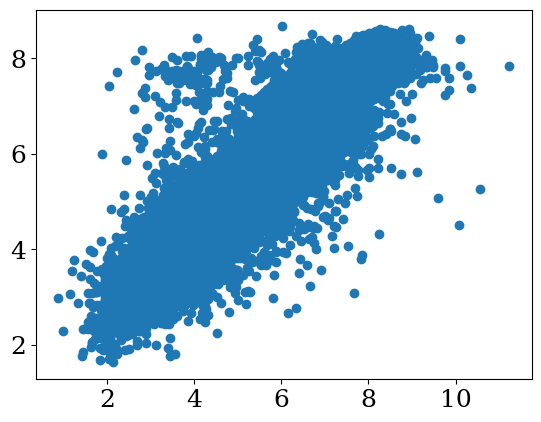

In [64]:
plt.scatter(y_test, predictions)
plt.show()

In [ ]:
#reconstructed_model = keras.models.load_model('model_diff.hdf5')

In [51]:
seqs = decode(X_test,100)

In [52]:
y_atg, atg, y_no, no = split_atg(X_test,seqs,y_test)

In [53]:
predictions_no = model.predict(no).reshape(-1)

564/564 [==============================] - 25s 45ms/step


In [54]:
predictions_atg = model.predict(atg).reshape(-1)

624/624 [==============================] - 27s 43ms/step


C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 0, 'Observed MRL'), Text(0, 0.5, 'Predicted MRL')]

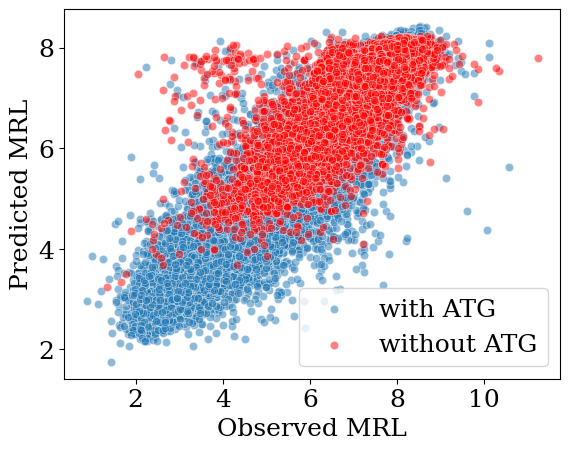

In [193]:
sns.scatterplot(y_atg, predictions_atg,linewidth = 0.5, alpha=0.5, label = 'with ATG')
ax = sns.scatterplot(y_no, predictions_no,
                linewidth = 0.5, alpha=0.5, label = 'without ATG', color = 'r', legend = 'auto')

ax.set(xlabel = 'Observed MRL', ylabel = 'Predicted MRL')

#ax.get_figure().savefig('rnn_different length')

In [55]:
seqs = decode(atg, 100)

new_atg = []
new_y_atg = []
for i in range(len(atg)):
    if len(seqs[i].split("n")[0])!=50:
        new_atg.append(atg[i])
        new_y_atg.append(y_atg[i])
    
new_atg = np.array(new_atg)
new_y_atg = np.array(new_y_atg)

seqs = decode(no, 100)

new_no = []
new_y_no = []
for i in range(len(no)):
    if len(seqs[i].split("n")[0])!=50:
        new_no.append(no[i])
        new_y_no.append(y_no[i])
    
new_no = np.array(new_no)
new_y_no = np.array(new_y_no)

In [56]:
predictions_no = model.predict(new_no).reshape(-1)

150/150 [==============================] - 7s 44ms/step


In [57]:
predictions_atg = model.predict(new_atg).reshape(-1)

148/148 [==============================] - 7s 50ms/step


In [58]:
r2_score(new_y_atg, predictions_atg)

0.7705501239129956

In [59]:
r2_score(new_y_no, predictions_no)

0.5390241566374543

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


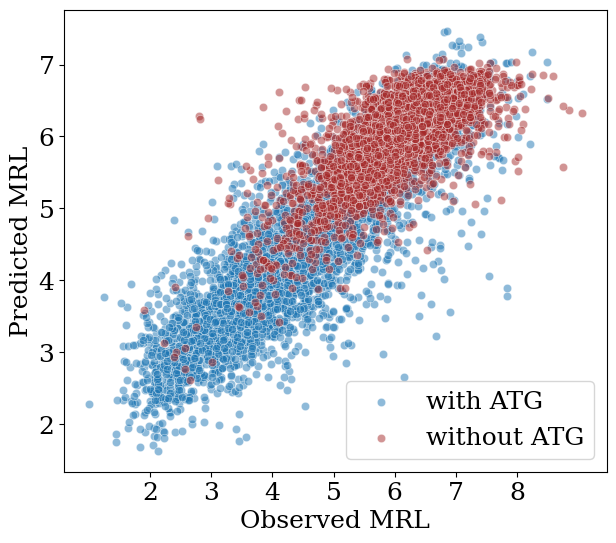

In [65]:
fig = plt.figure(figsize = (7,6))
sns.scatterplot(new_y_atg, predictions_atg,linewidth = 0.5, alpha=0.5, label = 'with ATG')
ax = sns.scatterplot(new_y_no, predictions_no,
                linewidth = 0.5, alpha=0.5, label = 'without ATG', color = 'brown', legend = 'auto')
ax.set(xlabel = 'Observed MRL', ylabel = 'Predicted MRL')
plt.xticks([2,3,4,5,6,7,8])
#plt.savefig("RNN_mrl_varying_length.pdf", bbox_inches = "tight")
plt.show()


In [62]:
r2_score(np.concatenate((new_y_atg, new_y_no), axis = None), np.concatenate((predictions_atg, predictions_no), axis = None))

0.8067575624450705

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


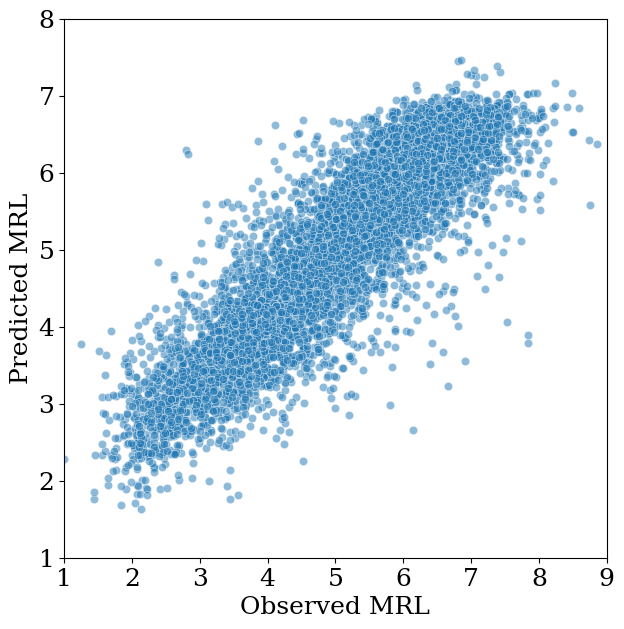

In [70]:
fig = plt.figure(figsize = (7,7))
#sns.scatterplot(new_y_atg, predictions_atg,linewidth = 0.5, alpha=0.5, label = 'with ATG')
ax = sns.scatterplot(np.concatenate((new_y_atg, new_y_no), axis = None), np.concatenate((predictions_atg, predictions_no), axis = None),
                linewidth = 0.5, alpha=0.5)
ax.set(xlabel = 'Observed MRL', ylabel = 'Predicted MRL')
plt.xlim(1,9)
plt.xticks([1,2,3,4,5,6,7,8,9])
plt.ylim(1,8)
plt.yticks([1,2,3,4,5,6,7,8])
plt.savefig("RNN_mrl_varying_length.pdf", bbox_inches = "tight")
plt.show()